In [1]:
!pip install --upgrade figures
!pip install geopandas
!pip install descartes
!pip install IPython
!pip install opencv-python
!pip install -U scikit-learn
from IPython import display
display.clear_output()

print("Installed libraries")

Installed libraries


Image segmented into polygons
Image representated
short checkpoints[]={0, 9, 18, 21, 24, 30, 36, 39, 42, 45, 48, 51, 54, 57, 63, 66, 69, 75, 78, 81, 84, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 153, 159, 162, 165, 171, 174, 183, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234, 237, 240, 243, 246, 249, 252, 258, 261, 267, 273, 276, 279, 285, 288, 291, 294, 297, 300, 303, 306, 309, 312, 315, 318, 321, 324, 327, 330, 333, 336, 339, 342};
int rawChangingPins[]={7, 8, -1, 9, 10, -1, 11, -1, 9, 10, -1, 8, -1, 3, 12, -1, 8, 13, -1, 5, 6, 8, 14, -1, 1, 14, -1, 7, 13, -1, 4, 7, 10, -1, 9, 12, 14, 17, -1, 5, 8, 11, 12, 15, 16, 18, -1, 13, 18, -1, 12, 17, -1, 1, -1, 16, -1, 4, 12, -1, 5, 11, 13, 14, 15, -1, 11, -1, 9, 10, 11, -1, 10, 11, -1, 9, 15, -1, 13, 14, -1, 12, -1, 1, 5, 16, -1, 1, 12, -1, 4, 17, -1, 18, -1, 6, 13, -1, 6, 9, 12, 13, 14, 16, -1, 4, 15, 17, 18, -1, 8, 10, 11, 13, -1, 14, -1, 5, 8, -1, 7, -1, 6, 14, -1, 4, 13, -1, 9, -1, 

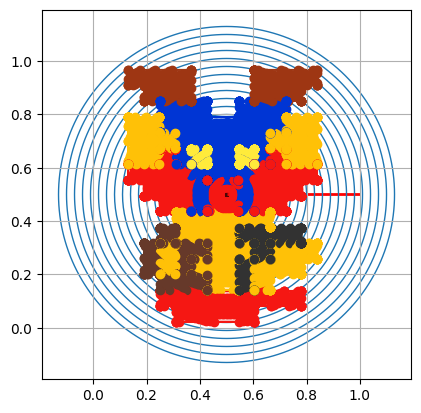

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
import math
import ctypes
import geopandas as gpd
import descartes
import shapely
import shapely.geometry as sg
from shapely.plotting import plot_polygon, plot_line
import sys
import numpy
import time
import cv2
import copy
import numpy as np
import argparse
import os

from sklearn.cluster import MiniBatchKMeans

# load the image and grab its width and height
rutaImgs=os.getcwd()+'\\images\\'
imageMario = cv2.imread(rutaImgs+'titoM.jpg')
imageZelda = cv2.imread(rutaImgs+'link2.jpg')

image=imageMario

(h, w) = image.shape[:2]

mask = np.zeros((h+2, w+2, 1), dtype = "uint8")

group = 1

thePolygons = []

#We get the different islands of the image
for x in range(h):
  for y in range(w):
    if(mask[x+1,y+1] == 0):

      print(image[x,y])

      colorOfPoly = image[x,y,:]

      connectivity = 4
      flags = connectivity
      flags |= cv2.FLOODFILL_MASK_ONLY
      newImage = image.copy()
      oldMask = mask.copy()
      cv2.floodFill(newImage, mask, (y,x), newVal=(0,0,0), loDiff=(20, 20, 20), upDiff=(20, 20, 20))

      cambiados = oldMask!=mask

      newImage[cambiados[1:-1,1:-1,:].reshape(h,w)] = [255,255,255]
      newImage[~cambiados[1:-1,1:-1,:].reshape(h,w)] = [0,0,0]

      #In case it's not the first group (outside), we get the vertexes
      if(group!=1):
        _, threshold = cv2.threshold(newImage, 110, 255, cv2.THRESH_BINARY)

        # Detecting contours in image.
        contours, _ = cv2.findContours(threshold[:,:,0], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        #cv2.drawContours(newImage, contours, -1, (0,255,0), 3)
        #cv2_imshow(newImage)
        points = contours[0].reshape(-1,2)

        for aux in points:
          x, y = aux
          cv2.circle(newImage, (x, y), 1, (0, 255, 0), -1)
        #cv2.imshow(newImage)

        points = points.astype(float)

        points[:,0] = points[:, 0]/h
        points[:,1] = points[:, 1]/w

        if(colorOfPoly[2] == 0 and colorOfPoly[1] == 0 and colorOfPoly[0] == 0):
          thePolygons.append(tuple((points, np.array([50, 50, 50]))))
        else:
          thePolygons.append(tuple((points, np.array([colorOfPoly[2], colorOfPoly[1], colorOfPoly[0]]))))

      group+=1
      display.clear_output() #comment this line if you want to see the polygons
      print("Image segmented")
      #print(np.count_nonzero(groups == 1))


numpy.set_printoptions(threshold=sys.maxsize)

def rounding(angle, step):
  if(angle%step == 0):
    return angle
  elif(angle%step < step/2):
    return angle - angle%step
  else:
    return angle + angle%step

def calculateAngle(thePoint):
  #We calculate the dot product

  coordinateVector = [0.5,0]
  pointVector = [thePoint[0]-0.5, thePoint[1]-0.5]

  numerator = pointVector[0]*coordinateVector[0] + pointVector[1]*coordinateVector[1]
  denominator = math.sqrt(pointVector[0]*pointVector[0] + pointVector[1]*pointVector[1])*math.sqrt(coordinateVector[0]*coordinateVector[0]+coordinateVector[1]*coordinateVector[1])
  radians = math.acos(numerator/denominator)

  if(thePoint[1]>= 0.5):
    return rounding(math.trunc(math.degrees(radians)), step)
  else:
    return rounding(math.trunc(360 - math.degrees(radians)), step)

def color( r,  g,  b):
  return (np.uint32(r) << 16) | (np.uint32(g) << 8) | b


##VARIABLES
numberOfLeds = 21

propOfCenter = 1
orbitDistance = 0.03

step = 3

circles = []
polygons = []

events = []

#The final Matrix
paintingMatrix = np.zeros((int(360/step),numberOfLeds+1))

variableTonta = 0
for aux in range(0, 360, step):
  paintingMatrix[variableTonta,0] = aux
  variableTonta+=1

##FIRST WE DRAW THE ORBIT OF THE 2D DISPLAY

  #We create the plot
ax = plt.gca()
ax.set_aspect(1)

  #First we draw the center of the orbit
ax.add_patch(plt.Circle((0.5, 0.5), orbitDistance*0.5, color='black', fill=True))

  #Then we draw the 0 angle line
plot_line(shapely.LineString([shapely.Point(0.5, 0.5), shapely.Point(1, 0.5)]), color='red', add_points=False)

  #We draw each of the led orbits
for x in range(numberOfLeds):
  point = sg.Point(0.5, 0.5).buffer(propOfCenter*orbitDistance + x*orbitDistance, resolution=50)
  circles.append(point)

  plot_polygon(circles[x], add_points=False, facecolor="none")


for aux in thePolygons:
  polygonMario = sg.Polygon(aux[0])
  polygons.append(polygonMario)
  plot_polygon(polygonMario, add_points=False, color=(aux[1][0]/255, aux[1][1]/255, aux[1][2]/255))

#WE GET AND PLOT THE INTERSECTION

  #We calculate the intersection
for orbit in range(numberOfLeds):

  index = 0


  for pol in polygons:
      #We calculate the intersection
    intersection = pol.intersection(circles[orbit])
      #We get the coordinates of the intersection

    if(type(intersection) == sg.polygon.Polygon):
      xx, yy = intersection.exterior.coords.xy

        #For each point we get the angle
      for aux in range(len(xx)):
        #We calculate the angle and change the value in it
        #But first we should check if the point is in orbit
        distanceOfPoint = math.sqrt((xx[aux]-0.5)*(xx[aux]-0.5) + (yy[aux]-0.5)*(yy[aux]-0.5))
        distanceOfOrbit = propOfCenter*orbitDistance + orbit*orbitDistance

        if(abs(distanceOfPoint - distanceOfOrbit) < 0.01):
          angle = calculateAngle([xx[aux], yy[aux]])
          if((len(np.argwhere(paintingMatrix[:,0] == angle))) != 0):
            paintingMatrix[int(np.argwhere(paintingMatrix[:,0] == angle)),orbit+1] = color(thePolygons[index][1][0], thePolygons[index][1][1], thePolygons[index][1][2])

        #We plot the intersection
      if(intersection.area > 0):
        plot_polygon(intersection, color=thePolygons[index][1]/255, facecolor="none")
      ax.plot

    else:
      polygonsAux = list(intersection.geoms)
      for pol in polygonsAux:
        xx, yy = pol.exterior.coords.xy

        #For each point we get the angle
        for aux in range(len(xx)):
          #We calculate the angle and change the value in it
          #But first we should check if the point is in orbit
          distanceOfPoint = math.sqrt((xx[aux]-0.5)*(xx[aux]-0.5) + (yy[aux]-0.5)*(yy[aux]-0.5))
          distanceOfOrbit = propOfCenter*orbitDistance + orbit*orbitDistance

          if(abs(distanceOfPoint - distanceOfOrbit) < 0.01):
            angle = calculateAngle([xx[aux], yy[aux]])
            if((len(np.argwhere(paintingMatrix[:,0] == angle))) != 0):
              paintingMatrix[int(np.argwhere(paintingMatrix[:,0] == angle)),orbit+1] = 1

          #We plot the intersection
        if(pol.area > 0):
          plot_polygon(pol, color=thePolygons[index][1]/255, facecolor="none")
        ax.plot

    index+=1

display.clear_output() #comment this line if you want to see the polygons
print("Image segmented into polygons")
print("Image representated")
paintingMatrix = paintingMatrix.astype(int)

##POSTPROCESSING##

  ##PART 1: REMOVE DUPLICATES

shouldDelete = np.ones(paintingMatrix.shape[0], dtype=bool)

currentRow = 0
prevRow = paintingMatrix.shape[0]-1

for row in paintingMatrix[:,1:]:

  #We check if the next one is the same as this
  if(list(row) == list(paintingMatrix[prevRow, 1:])):
    shouldDelete[currentRow] = False

  currentRow+=1
  if(currentRow!=1):
    prevRow+=1
  else:
    prevRow=0

paintingMatrix = paintingMatrix[np.array(shouldDelete)]

  ##PART 2: CONVERT TO ADEQUATE FORMAT
angles = []
ledsToChange = []
colorsToChange = []

currentRow = 0
previousRow = paintingMatrix.shape[0]-1
for row in paintingMatrix[:,:]:

  ledsList = []
  colorsList = []

  for aux in range(len(row)-1):
    if(row[aux+1] != paintingMatrix[previousRow, aux+1]):
      ledsList.append(aux)
      colorsList.append(row[aux+1])

  angles.append(int(row[0]))
  ledsToChange.append(ledsList)
  colorsToChange.append(colorsList)

  currentRow+=1
  if(currentRow != 1):
    previousRow+=1
  else:
    previousRow=0

#print(colorsToChange)


ledsChangePlain=[]
colorsChangePlain=[]
for i in ledsToChange:
  for u in i:
    ledsChangePlain.append(u)
  ledsChangePlain.append(-1)

for i in colorsToChange:
  for u in i:
    colorsChangePlain.append(u)
  colorsChangePlain.append(-1)


printeableCheckPoint = ', '.join(str(x) for x in angles)
printeableLeds = ', '.join(str(x) for x in ledsChangePlain)
printeableColor = ', '.join(str(x) for x in colorsChangePlain)

time.sleep(1)

print("short checkpoints[]={"+printeableCheckPoint+"};")
print("int rawChangingPins[]={"+printeableLeds+"};")
print("uint32_t rawColored[]={"+printeableColor+"};")
print("")

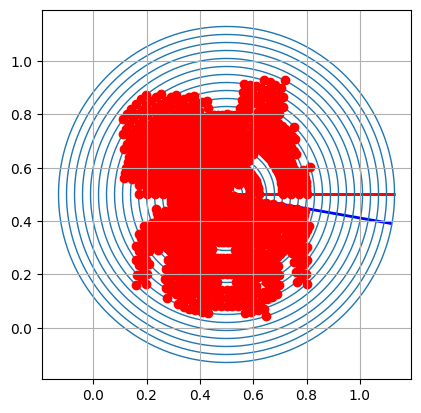

In [8]:
#We simulate the effect

arduinoAngles = np.zeros((len(angles)))
arduinoLedsChangePlain = np.zeros((len(angles)), dtype=object)
arduinoColorsChangePlain = np.zeros((len(angles)), dtype=object)

def converter():

  elemento=0;
  index=0;
  elemColor=0;

  for numAngle in range(len(angles)):
      #We introduce: ANGLE
    arduinoAngles[numAngle] = angles[numAngle];
    elemento=ledsChangePlain[index];

    arduinoLedsChangePlain[numAngle] = []
    arduinoColorsChangePlain[numAngle] = []

    while(elemento!=-1):
      arduinoLedsChangePlain[numAngle].append(elemento)
      elemColor=colorsChangePlain[index]
      arduinoColorsChangePlain[numAngle].append(elemColor)

      index+=1
      elemento=ledsChangePlain[index]
    index+=1

def paintAState(index):
  for auxIndex in range(len(arduinoLedsChangePlain[index])):
    ledState[arduinoLedsChangePlain[index][auxIndex]] = arduinoColorsChangePlain[index][auxIndex]

radarPointerOrigin = (0.5,0.5)
radarPointerLenght = numberOfLeds*orbitDistance

currentAngle = 350

  #We create the plot
ax = plt.gca()
ax.set_aspect(1)

  #First we draw the center of the orbit
ax.add_patch(plt.Circle((0.5, 0.5), orbitDistance*0.5, color='black', fill=True))

  #Then we draw the 0 angle line
plot_line(shapely.LineString([shapely.Point(radarPointerOrigin), shapely.Point(radarPointerOrigin[0]+radarPointerLenght, radarPointerOrigin[1])]), color='red', add_points=False)

  #Then we draw the current angle line
cos = math.cos(math.radians(currentAngle))
sin = math.sin(math.radians(currentAngle))

finalPointOfAngle = [radarPointerOrigin[0] + radarPointerLenght*cos, radarPointerOrigin[1] + radarPointerLenght*sin]

plot_line(shapely.LineString([shapely.Point(radarPointerOrigin), shapely.Point(finalPointOfAngle)]), color='blue', add_points=False)

  #Then we draw the current angle line
plot_line(shapely.LineString([shapely.Point(radarPointerOrigin), shapely.Point(radarPointerOrigin[0]+radarPointerLenght, radarPointerOrigin[1])]), color='red', add_points=False)

  #We draw each of the led orbits
for x in range(numberOfLeds):
  point = sg.Point(0.5, 0.5).buffer(propOfCenter*orbitDistance + x*orbitDistance, resolution=50)
  circles.append(point)

  plot_polygon(circles[x], add_points=False, facecolor="none")


  #Now we draw the different leds from the origin to current angle
index = 0
angle = angles[index]

converter()

ledState = np.zeros((numberOfLeds))

for angle in range(0, currentAngle, step):

  try:
    index = list(arduinoAngles).index(angle)
  except:
    index = -1

  #Paint the colors
    #Get the state
  if(index!=-1):
    paintAState(index)
    #Paint the state
  cos = math.cos(math.radians(angle))
  sin = math.sin(math.radians(angle))

  finalPointOfAngle = [radarPointerOrigin[0] + radarPointerLenght*cos, radarPointerOrigin[1] + radarPointerLenght*sin]

  currentLine = [finalPointOfAngle[0] - radarPointerOrigin[0], finalPointOfAngle[1] - radarPointerOrigin[1]]

  indexInLed = 0
  for aux in ledState:
    if(aux!=0):
      thePoint = [(indexInLed/numberOfLeds)*i for i in currentLine]
      ax.scatter(thePoint[0] + radarPointerOrigin[0], thePoint[1] + radarPointerOrigin[1], color='r')
    indexInLed+=1

